In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import load_wine
import os

In [2]:
plot_dir = r"C:\Users\alepa\Desktop\Data Science\[1] 2nd Semester\Optimization for Data Science\Homework\Plots"
os.makedirs(plot_dir, exist_ok=True)

In [3]:
device = torch.device('cpu')

lr = 6e-6
epochs = 20000
PAT = 100
TOL = 1e-2

torch.manual_seed(17)

In [4]:
def f(X, A, Z):
    logits = torch.mm(A, X)
    log_probs = -F.log_softmax(logits, dim=1)
    loss = (log_probs * Z).sum() / Z.sum()

    return loss


def P(X, A):
    return F.softmax(torch.mm(A, X), dim=1)


def gradient(X, A, Z):
    logits = torch.mm(A, X)
    probs = F.softmax(logits, dim=1)
    grad = torch.mm(A.t(), probs - Z)

    return grad

In [5]:
def ACC(X, A, b_i):
    with torch.no_grad():
        logits = torch.mm(A, X)
        predictions = torch.argmax(logits, dim=1)

        accuracy = (predictions == b_i).float().mean().item()

    return accuracy

In [6]:
def GD(X, A, Z, b_i, epochs, lr, PAT, TOL):
    accuracies = []
    times = []
    start_time = time.process_time()
    best_loss = float('inf')
    PAT_counter = 0

    for epoch in range(epochs):
        update = gradient(X, A, Z)
        X -= lr * update
        
        current_loss = f(X, A, Z)
        if current_loss < best_loss - TOL:
            best_loss = current_loss
            PAT_counter = 0
        else:
            PAT_counter += 1
        
        if PAT_counter >= PAT:
            print(f"stopping at epoch {epoch}")
            break

        current_time = time.process_time() - start_time
        accuracy = ACC(X, A, b_i)
        accuracies.append(accuracy)
        times.append(current_time)

    return accuracies, times



def BCGD_randomized(X, A, Z, b_i, epochs, lr, block_size, PAT, TOL):
    accuracies = []
    times = []
    start_time = time.process_time()
    best_loss = float('inf')
    PAT_counter = 0

    for epoch in range(epochs):
        block_indices = torch.randint(0, X.shape[1], (block_size,)).tolist()
        update_block = gradient(X[:, block_indices], A, Z[:, block_indices])
        X[:, block_indices] -= lr * update_block
        
        current_loss = f(X, A, Z)
        if current_loss < best_loss - TOL:
            best_loss = current_loss
            PAT_counter = 0
        else:
            PAT_counter += 1
        
        if PAT_counter >= PAT:
            print(f"stopping at epoch {epoch}")
            break

        current_time = time.process_time() - start_time
        accuracy = ACC(X, A, b_i)
        accuracies.append(accuracy)
        times.append(current_time)

    return accuracies, times



def BCGD_Gauss_Southwell(X, A, Z, b_i, epochs, lr, block_size, PAT, TOL):
    accuracies = []
    times = []
    start_time = time.process_time()
    best_loss = float('inf')
    PAT_counter = 0

    for epoch in range(epochs):
        norms = torch.norm(gradient(X, A, Z), dim=0)
        _, block_indices = torch.topk(norms, block_size, largest=True)
        update_block = gradient(X[:, block_indices], A, Z[:, block_indices])
        X[:, block_indices] -= lr * update_block
        
        current_loss = f(X, A, Z)
        if current_loss < best_loss - TOL:
            best_loss = current_loss
            PAT_counter = 0
        else:
            PAT_counter += 1
        
        if PAT_counter >= PAT:
            print(f"stopping at epoch {epoch}")
            break

        current_time = time.process_time() - start_time
        accuracy = ACC(X, A, b_i)
        accuracies.append(accuracy)
        times.append(current_time)

    return accuracies, times

In [7]:
def hessian(A):
    d, m = A.shape
    H = torch.zeros(m, m, device=device)

    for i in range(d):
        x = A[i].view(-1, 1)
        H += torch.mm(x, x.t())

    return H

def lipschitz_hessian(A):
    H = hessian(A)
    L = torch.svd(H).S.max()

    return L


def compute_block_stepsize(A, block_indices):
    col_norms = torch.norm(A[:, block_indices], dim=0) ** 2
    return 1 / col_norms


def compute_exact_stepsize(A, X):
    diag = torch.diag(torch.mm(A.t(), A))
    return 1 / diag



In [8]:
def RES(X_init, A, Z, b_i, epochs, block_size, alpha_fixed, alpha_block, alpha_exact, PAT, TOL):
    results = {'GD': {}, 'BCGD_randomized': {}, 'BCGD_Gauss_Southwell': {}}

    X_fixed = X_init.clone()
    results['GD']['Fixed'] = GD(X_fixed, A, Z, b_i, epochs, alpha_fixed, PAT, TOL)
    X_fixed = X_init.clone()
    results['BCGD_randomized']['Fixed'] = BCGD_randomized(X_fixed, A, Z, b_i, epochs, alpha_fixed, block_size, PAT, TOL)
    X_fixed = X_init.clone()
    results['BCGD_Gauss_Southwell']['Fixed'] = BCGD_Gauss_Southwell(X_fixed, A, Z, b_i, epochs, alpha_fixed, block_size, PAT, TOL)

    X_block = X_init.clone()
    results['GD']['Block'] = GD(X_block, A, Z, b_i, epochs, alpha_block, PAT, TOL)
    X_block = X_init.clone()
    results['BCGD_randomized']['Block'] = BCGD_randomized(X_block, A, Z, b_i, epochs, alpha_block, block_size, PAT, TOL)
    X_block = X_init.clone()
    results['BCGD_Gauss_Southwell']['Block'] = BCGD_Gauss_Southwell(X_block, A, Z, b_i, epochs, alpha_block, block_size, PAT, TOL)

    X_exact = X_init.clone()
    results['GD']['Exact'] = GD(X_exact, A, Z, b_i, epochs, alpha_exact, PAT, TOL)
    X_exact = X_init.clone()
    results['BCGD_randomized']['Exact'] = BCGD_randomized(X_exact, A, Z, b_i, epochs, alpha_exact, block_size, PAT, TOL)
    X_exact = X_init.clone()
    results['BCGD_Gauss_Southwell']['Exact'] = BCGD_Gauss_Southwell(X_exact, A, Z, b_i, epochs, alpha_exact, block_size, PAT, TOL)

    return results

In [9]:
def plot_results(results, stepsize_name):
    sns.set_theme(style="white", palette="bright")

    plt.figure(figsize=(10, 6))

    for algo_name, (accuracies, times) in results.items():
        sns.lineplot(x=times, y=accuracies, label=algo_name, linewidth=1.5, errorbar=None)

    plt.xlabel('CPU Time (seconds)', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(title='Algorithm', fontsize=12, title_fontsize=13)
    plt.show()


def plot_stepsizes_fixed_block_exact(fixed, block, exact, dataset_name):
    sns.set_theme(style="white", palette="bright")

    plt.figure(figsize=(10, 6))

    sns.lineplot(x=range(len(fixed)), y=fixed, label='Fixed', linewidth=1.5, errorbar=None)
    sns.lineplot(x=range(len(block)), y=block, label='Block', linewidth=1.5, errorbar=None)
    sns.lineplot(x=range(len(exact)), y=exact, label='Exact', linewidth=1.5, errorbar=None)

    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Step size', fontsize=14)
    plt.legend(title='Step size type', fontsize=12, title_fontsize=13)
    plt.show()



In [10]:
def SYNTH():
    d, m, k = 1000, 50, 50
    A = torch.randn(d, m, device=device)
    X = torch.randn(m, k, device=device)
    E = torch.randn(d, k, device=device)
    noised_matrix = torch.mm(A, X) + E
    b_i = torch.argmax(noised_matrix, dim=1)
    Z = torch.zeros(d, k, device=device)
    Z[torch.arange(d), b_i] = 1

    return noised_matrix, X, Z, b_i, k


def MNIST():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

    def get_batch(loader):
        for images, b_i in loader:
            return images.view(images.shape[0], -1).to(device), b_i.to(device)

    A, Y = get_batch(train_loader)
    k = 10
    d, m = A.shape
    X = torch.randn(m, k, device=device)
    E = torch.randn(d, k, device=device)
    Z = F.one_hot(Y, num_classes=k).float().to(device)

    return A, X, Z, Y, k


def WINE():
    wine = load_wine()
    A = torch.tensor(wine.data, dtype=torch.float32).to(device)
    labels = torch.tensor(wine.target, dtype=torch.long).to(device)

    d, m = A.shape
    k = len(np.unique(labels))
    X = torch.randn(m, k, device=device)
    E = torch.randn(d, k, device=device)
    b_i = labels
    Z = torch.zeros(d, k, device=device)
    Z[torch.arange(d), b_i] = 1

    return A, X, Z, b_i, k



In [11]:
def Run(dataset_preparation_fn, epochs, block_size, PAT, TOL):
    A, X_init, Z, b_i, k = dataset_preparation_fn()
    d, m = A.shape

    if block_size > m:
        block_size = m

    L = lipschitz_hessian(A)

    alpha_fixed_value = 1 / L

    block_indices = torch.randint(0, k, (block_size,))

    alpha_block_value = compute_block_stepsize(A, block_indices).mean().item()
    alpha_exact_value = compute_exact_stepsize(A, X_init).mean().item()

    results = RES(X_init, A, Z, b_i, epochs, block_size, alpha_fixed_value, alpha_block_value, alpha_exact_value, PAT, TOL)

    return results, alpha_fixed_value, alpha_block_value, alpha_exact_value

stopping at epoch 8152
stopping at epoch 11236
stopping at epoch 9231
stopping at epoch 2502
stopping at epoch 3483
stopping at epoch 2938
stopping at epoch 2593
stopping at epoch 3613
stopping at epoch 2939


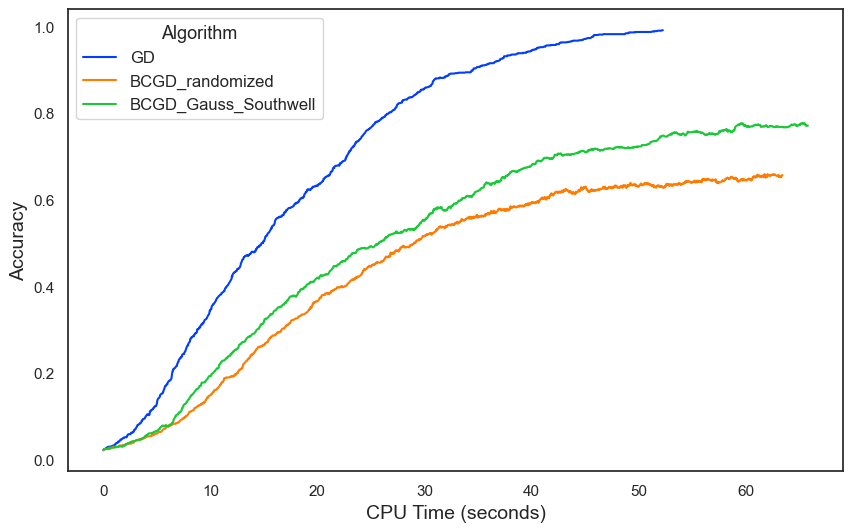

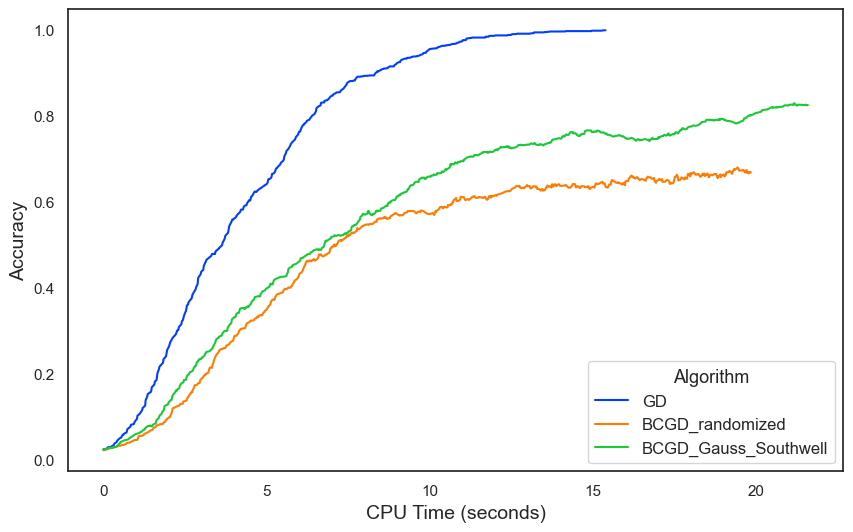

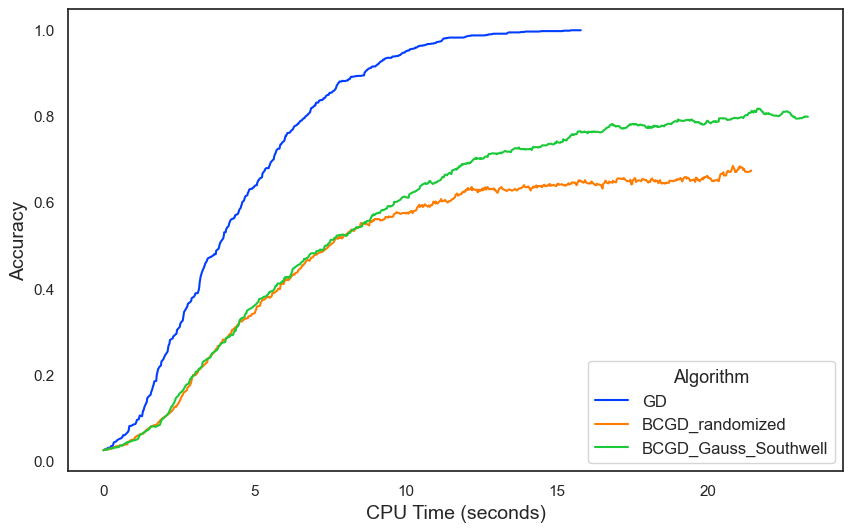

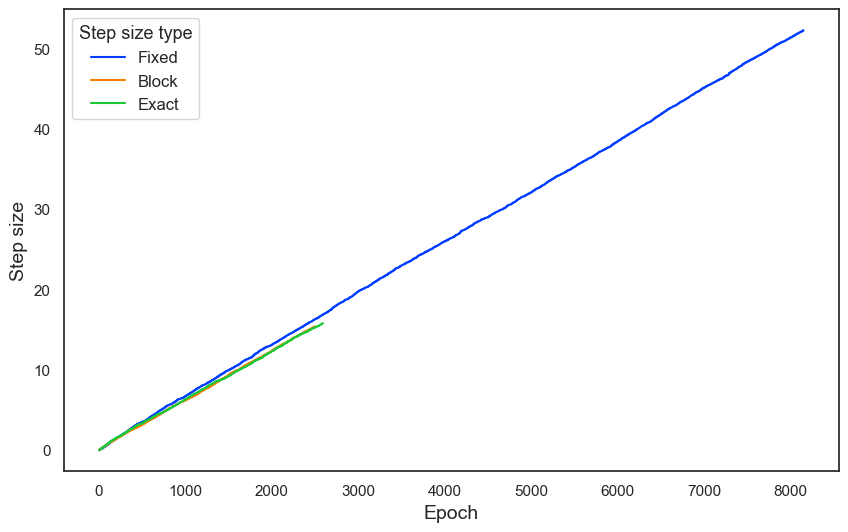

In [12]:
block_size = 35
synthetic_results, fixed_stepsize, block_stepsize, exact_stepsize = Run(SYNTH, epochs, block_size, PAT, TOL)
plot_results({k: v['Fixed'] for k, v in synthetic_results.items()}, 'Fixed')
plot_results({k: v['Block'] for k, v in synthetic_results.items()}, 'Block')
plot_results({k: v['Exact'] for k, v in synthetic_results.items()}, 'Exact')

plot_stepsizes_fixed_block_exact(
    synthetic_results['GD']['Fixed'][1],
    synthetic_results['GD']['Block'][1],
    synthetic_results['GD']['Exact'][1],
    'Synthetic'
)

stopping at epoch 14788
stopping at epoch 9728
stopping at epoch 14800
stopping at epoch 428
stopping at epoch 329
stopping at epoch 652
stopping at epoch 426
stopping at epoch 248
stopping at epoch 613


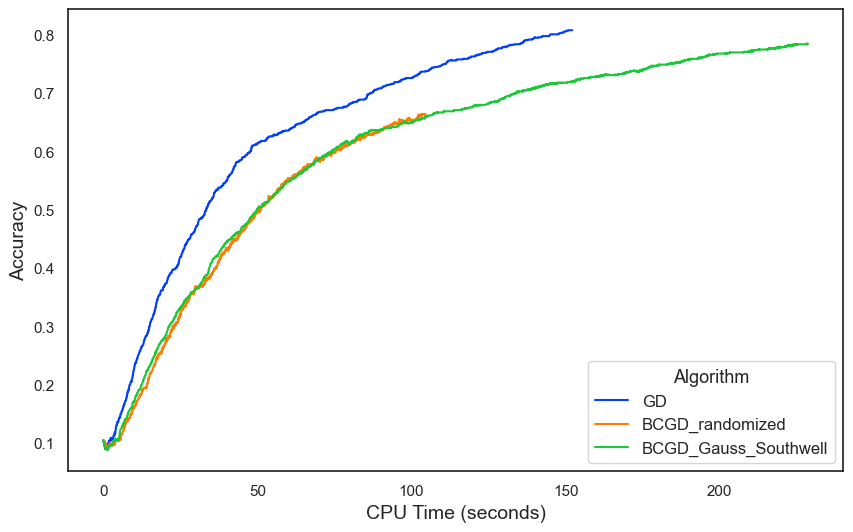

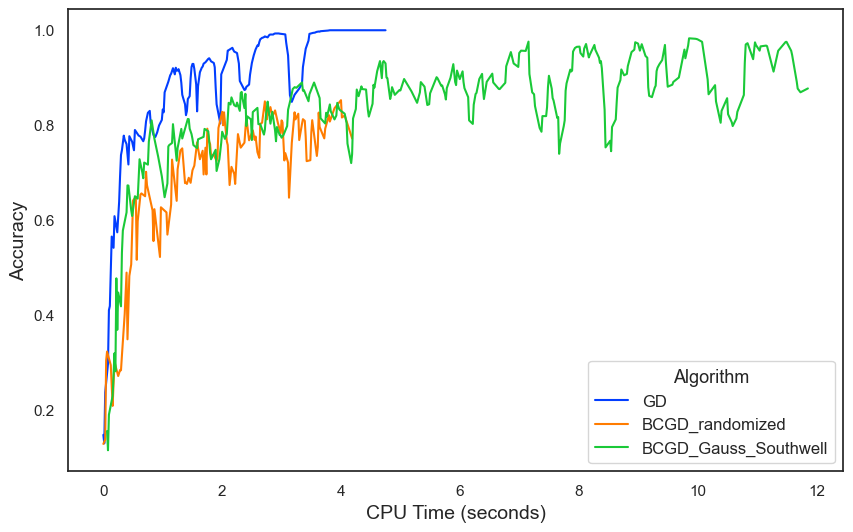

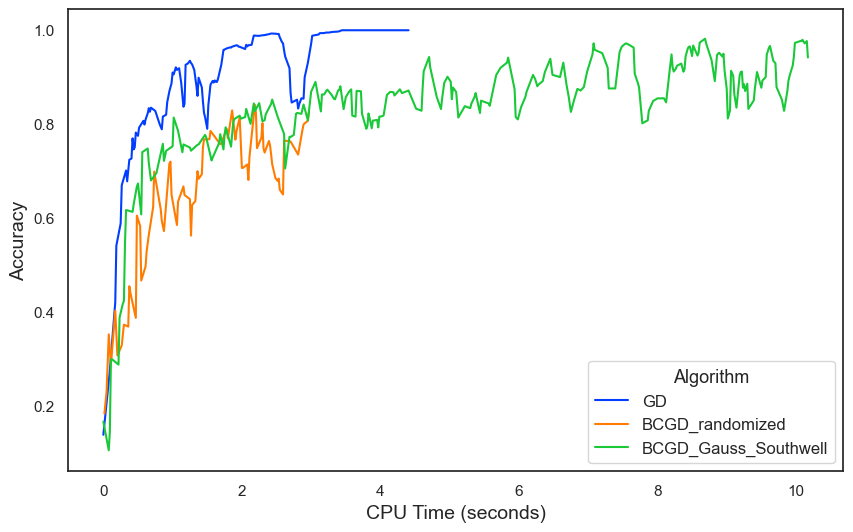

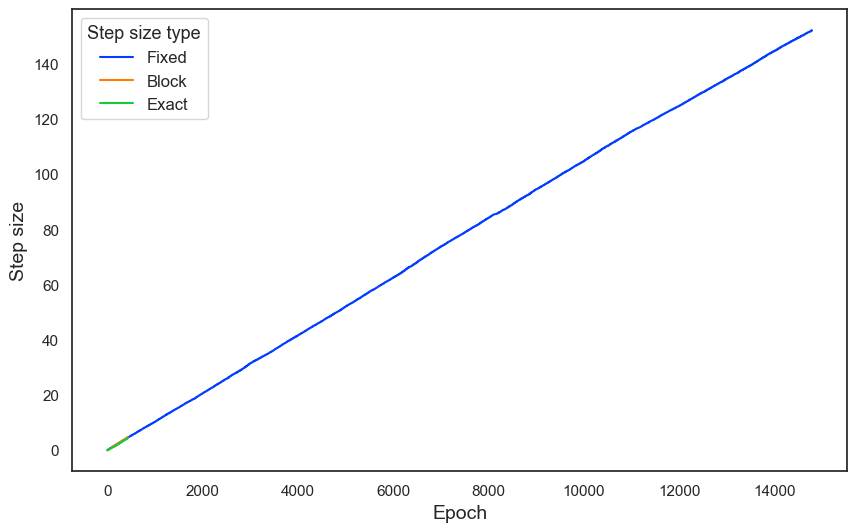

In [13]:
block_size = 9
mnist_results, fixed_stepsize, block_stepsize, exact_stepsize = Run(MNIST, epochs, block_size, PAT, TOL)
plot_results({k: v['Fixed'] for k, v in mnist_results.items()}, 'Fixed')
plot_results({k: v['Block'] for k, v in mnist_results.items()}, 'Block')
plot_results({k: v['Exact'] for k, v in mnist_results.items()}, 'Exact')

plot_stepsizes_fixed_block_exact(
    mnist_results['GD']['Fixed'][1],
    mnist_results['GD']['Block'][1],
    mnist_results['GD']['Exact'][1],
    'MNIST'
)


stopping at epoch 2534
stopping at epoch 169
stopping at epoch 156
stopping at epoch 169
stopping at epoch 179
stopping at epoch 115
stopping at epoch 179


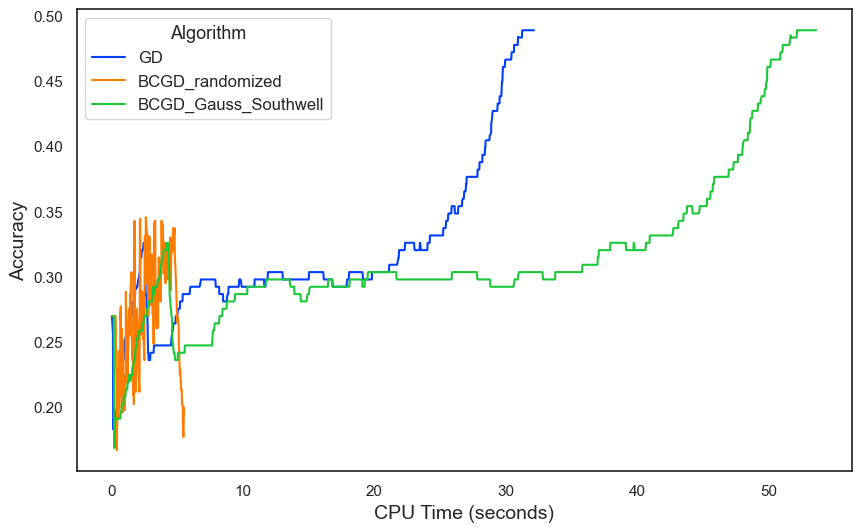

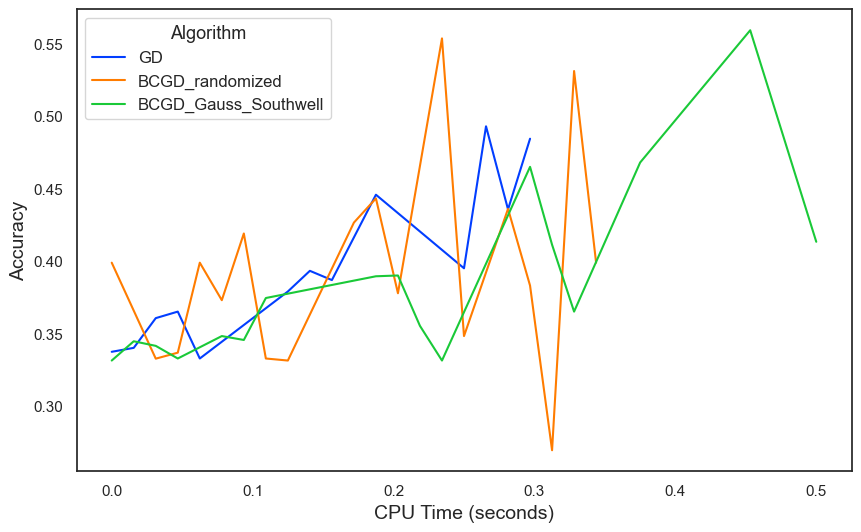

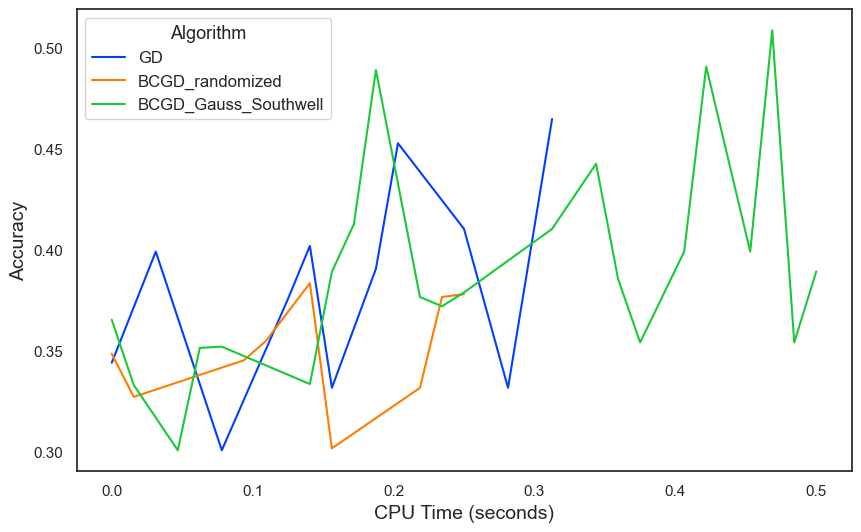

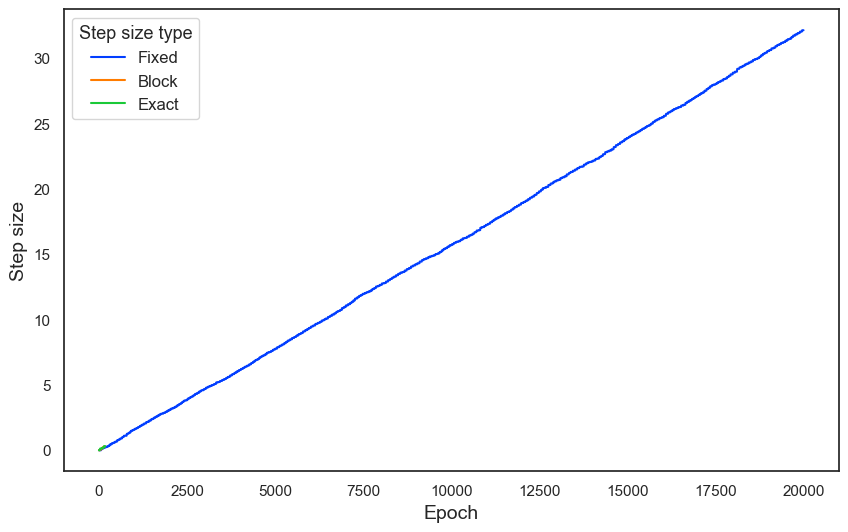

In [14]:
block_size = 3
wine_results, fixed_stepsize, block_stepsize, exact_stepsize = Run(WINE, epochs, block_size, PAT, TOL)
plot_results({k: v['Fixed'] for k, v in wine_results.items()}, 'Fixed')
plot_results({k: v['Block'] for k, v in wine_results.items()}, 'Block')
plot_results({k: v['Exact'] for k, v in wine_results.items()}, 'Exact')

plot_stepsizes_fixed_block_exact(
    wine_results['GD']['Fixed'][1],
    wine_results['GD']['Block'][1],
    wine_results['GD']['Exact'][1],
    'Wine'
)